In [423]:
import plotting
import importlib
importlib.reload(plotting)
import numpy as np
import transforms
import sampling
import matplotlib.pyplot as plt
import sys
import scipy
#np.set_printoptions(suppress=True)
import chernoff
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)
import methods
import prop
importlib.reload(prop)
import pipeline
importlib.reload(pipeline)
import chernoff
importlib.reload(chernoff)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'DejaVu Serif'
mpl.rcParams["mathtext.default"] = 'rm'
mpl.rcParams["mathtext.fontset"]= 'dejavuserif'
import random

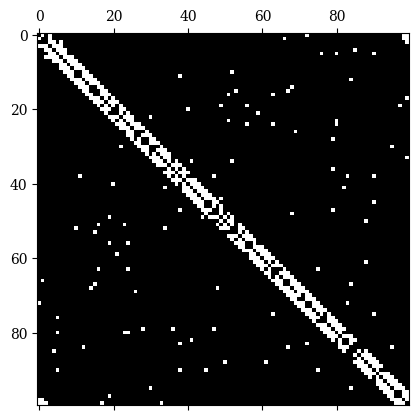

In [438]:
def gen_watts_strogatz(N, d, p):
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(d):
            A[i][(i + (j+1)) %N] = 1
            A[i][(i - (j+1)) %N] = 1
    for i in range(N):
        for j in range(d):
            if random.random() < p:
                A[i][(i + (j+1)) %N] = 0
                A[(i + (j+1)) %N][i] = 0
                h = random.randint(0,N)
                A[i][h] = 1
                A[h][i] = 1
    return A

plt.matshow(gen_watts_strogatz(100,3,0.2))

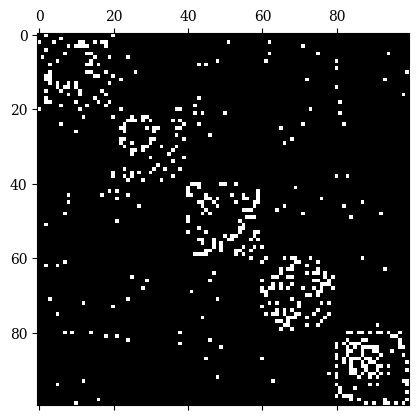

In [447]:
def gen_modular(N, M, C, p):
    A = np.zeros((N*C,N*C))
    ep = M/(0.5*N*N)
    for comm in range(C):
        for i in range(N):
            for j in range(i+1,N):
                if random.random() < ep:
                    A[comm*N + i][comm*N + j] = 1
                    A[comm*N + j][comm*N + i] = 1
    for comm in range(C):
        for i in range(N):
            for j in range(i+1,N):
                if A[comm*N + i][comm*N + j] == 1 and random.random() < p:
                    hc = comm
                    while hc == comm: hc = random.randint(0,C-1)
                    k = random.randint(0,N-1)
                    A[comm*N + i][comm*N + j] = 0
                    A[comm*N + j][comm*N + i] = 0
                    A[comm*N + i][hc*N + k] = 1
                    A[hc*N + k][comm*N + i] = 1
    return A

plt.matshow(gen_modular(20,50,5,0.2))

In [416]:
ga,gb = 0.6, 0.25
#for ga in [0.5, 0.8, 1]:
#    for gb in [0.1, 0.2, 0.3, 0.5, 0.8, 1, 1.5, 2]:
print(ga,gb,np.mean(sampling.truncated_sample(scipy.stats.gamma, [ga,0,1/gb], 1, 100_000)))

0.6 0.25 0.3530280923038232


In [417]:
def identity_transform(X):
    return np.copy(X)

def log_transform(X):
    X = np.copy(X)
    X[X == 0.999] = 1
    return np.log(X)

def stouffer_transform(X):
    X = X/1.01
    res = scipy.stats.norm.ppf(X)
    res[res == scipy.stats.norm.ppf(0.999/1.01)] = 0
    return res

def george_transform(X):
    X = X/1.01
    res = np.log(X) - np.log(1 - X)
    badx = 0.999/1.01
    res[res == np.log(badx/(1-badx))] = 0
    return res

def log_likelihood(X):
    trunc = scipy.stats.gamma.cdf(1, ga,0,1/gb) - scipy.stats.gamma.cdf(0, ga,0,1/gb)
    res = scipy.stats.gamma.pdf(X, ga,0,1/gb)/trunc
    res[res == scipy.stats.gamma.pdf(0.999, ga,0,1/gb)] = 1
    return np.log(res)

def threshold_001(X):
    succ = X < 0.01
    R = np.zeros(X.shape)
    R[succ] = 1
    return R

def threshold_005(X):
    succ = X < 0.05
    R = np.zeros(X.shape)
    R[succ] = 1
    return R

def threshold_010(X):
    succ = X < 0.1
    R = np.zeros(X.shape)
    R[succ] = 1
    return R

TRANSFORMS = [
    [log_likelihood, "Log-Likelihood"],
    (log_transform, "Fisher"),
    (george_transform, "George"),
    (stouffer_transform, "Stouffer"),
    (identity_transform, "Identity"),
    (threshold_005, "0.01 Threshold"),
    (threshold_005, "0.05 Threshold"),
    (threshold_010, "0.10 Threshold"),
]

100%|██████████| 51/51 [00:05<00:00,  9.58it/s]


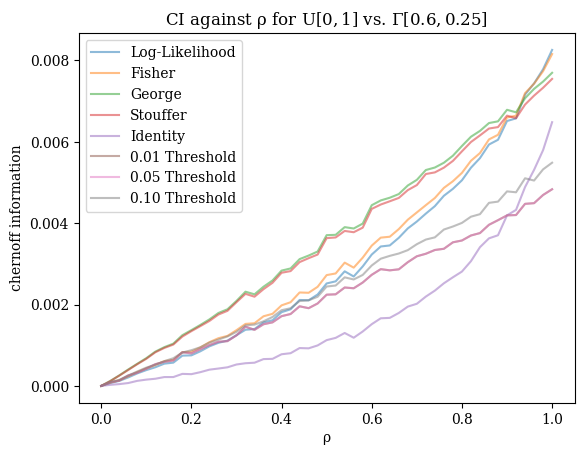

In [418]:
pi = 0.2
gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
model = sampling.WSBM(f"$\\Gamma[{ga},{gb}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
chernoff.plot_transforms_new(model, TRANSFORMS)

  0%|          | 0/6 [00:00<?, ?it/s]

0.2 0.2 [np.float64(0.04765210489853329), np.float64(0.04719407879266974), np.float64(0.047765951915289984), np.float64(0.055867228854420505), np.float64(0.04260099103393977), np.float64(0.052478050790552816), np.float64(0.052478050790552816), np.float64(0.050153211105044844)]
0.2 0.6 [np.float64(0.05430012828283404), np.float64(0.05268232476194696), np.float64(0.05394488754984604), np.float64(0.06489384243042869), np.float64(0.05171085405102277), np.float64(0.059824121697117344), np.float64(0.059824121697117344), np.float64(0.05813497169232352)]
0.2 1.0 [np.float64(0.06084061391173731), np.float64(0.057717542903648396), np.float64(0.059655559839069144), np.float64(0.0739016226964708), np.float64(0.06168380263022155), np.float64(0.06764955366124756), np.float64(0.06764955366124756), np.float64(0.06685159567800378)]
0.2 1.4 [np.float64(0.06749511343180402), np.float64(0.06259273270724011), np.float64(0.06513521725761581), np.float64(0.08263185779857558), np.float64(0.07187144400702605),

 17%|█▋        | 1/6 [00:02<00:10,  2.17s/it]

0.2 2.2 [np.float64(0.07970440964004465), np.float64(0.07081866692436696), np.float64(0.0741901077945373), np.float64(0.09799644204129755), np.float64(0.09123237132975409), np.float64(0.09012152010155623), np.float64(0.09012152010155623), np.float64(0.09263684480428146)]
0.4 0.2 [np.float64(0.0207597506723184), np.float64(0.020548973096420245), np.float64(0.019985325151030894), np.float64(0.020141819932761398), np.float64(0.01626555154841486), np.float64(0.015241347353120278), np.float64(0.015241347353120278), np.float64(0.015964179762381826)]
0.4 0.6 [np.float64(0.026303458509104857), np.float64(0.02538098836168673), np.float64(0.025486111445079743), np.float64(0.026376165747281848), np.float64(0.022201448335552154), np.float64(0.018695435185782847), np.float64(0.018695435185782847), np.float64(0.020193302692328025)]
0.4 1.0 [np.float64(0.03212267308245675), np.float64(0.03010996315689511), np.float64(0.030959713353656427), np.float64(0.03282901402417857), np.float64(0.028599876790467

 33%|███▎      | 2/6 [00:04<00:08,  2.19s/it]

0.4 2.2 [np.float64(0.05161215354240266), np.float64(0.04431940708863921), np.float64(0.047360200957588396), np.float64(0.05314636263614565), np.float64(0.05052991395981454), np.float64(0.03326069087947131), np.float64(0.03326069087947131), np.float64(0.03900329700676548)]
0.6 0.2 [np.float64(0.007736368050841795), np.float64(0.007663333272208708), np.float64(0.007211391125793218), np.float64(0.007041616701137404), np.float64(0.005991955323282616), np.float64(0.0045293780471787), np.float64(0.0045293780471787), np.float64(0.005134408415055336)]
0.6 0.6 [np.float64(0.011210325005394725), np.float64(0.010762178997750949), np.float64(0.010733547457754436), np.float64(0.010728428364965978), np.float64(0.00952867347554015), np.float64(0.005980543343460872), np.float64(0.005980543343460872), np.float64(0.007183700017576532)]
0.6 1.0 [np.float64(0.01535417883042678), np.float64(0.014269273656004666), np.float64(0.014736820622035863), np.float64(0.014983091454375395), np.float64(0.013674219968

 50%|█████     | 3/6 [00:06<00:06,  2.19s/it]

0.6 2.2 [np.float64(0.031121804452062887), np.float64(0.026186477736064973), np.float64(0.028691843288689792), np.float64(0.030497454299542294), np.float64(0.02990773922699802), np.float64(0.013693745326845832), np.float64(0.013693745326845832), np.float64(0.017980948631988992)]
0.8 0.2 [np.float64(0.0019100932898799877), np.float64(0.0018806076612755268), np.float64(0.0017795774069877522), np.float64(0.0017458972858452662), np.float64(0.0015712100594996725), np.float64(0.0009021079955333217), np.float64(0.0009021079955333217), np.float64(0.001113725996529048)]
0.8 0.6 [np.float64(0.003754620300738785), np.float64(0.003513924813230096), np.float64(0.0036145001812787868), np.float64(0.003620831181067739), np.float64(0.0034004886147583346), np.float64(0.0014693500509736519), np.float64(0.0014693500509736519), np.float64(0.001972750806750804)]
0.8 1.0 [np.float64(0.006300534102654668), np.float64(0.005590358702968368), np.float64(0.00608137637157206), np.float64(0.006183851357915888), np.

 67%|██████▋   | 4/6 [00:08<00:04,  2.19s/it]

0.8 2.2 [np.float64(0.017796285385534166), np.float64(0.014279321825329164), np.float64(0.016428970572191462), np.float64(0.01722399361131548), np.float64(0.017502286685572355), np.float64(0.005216250525582069), np.float64(0.005216250525582069), np.float64(0.00793884779725634)]
1.0 0.2 [np.float64(8.551181416455972e-05), np.float64(6.46434807506785e-05), np.float64(7.984917200278335e-05), np.float64(8.2608010931547e-05), np.float64(8.551181448146483e-05), np.float64(1.1729756220969778e-05), np.float64(1.1729756220969778e-05), np.float64(2.4286948261453833e-05)]
1.0 0.6 [np.float64(0.0007460438037355298), np.float64(0.0005482504971549562), np.float64(0.0006869172706876132), np.float64(0.0007147951818961993), np.float64(0.0007460438036484551), np.float64(0.00010893771621841002), np.float64(0.00010893771621841002), np.float64(0.00020729506976622548)]
1.0 1.0 [np.float64(0.002050612358806361), np.float64(0.0015155738600629437), np.float64(0.0018857504192000608), np.float64(0.00196433907688

 83%|████████▎ | 5/6 [00:10<00:02,  2.10s/it]

1.0 2.2 [np.float64(0.009675068309102504), np.float64(0.006906972246401133), np.float64(0.008656651995934302), np.float64(0.009120317789905267), np.float64(0.009675068309102752), np.float64(0.0015720772127840923), np.float64(0.0015720772127840923), np.float64(0.002899077639698752)]
1.2 0.2 [np.float64(0.00048125844124969724), np.float64(0.00046012684300603124), np.float64(0.0003330324551450627), np.float64(0.0003192131076670373), np.float64(0.00027647134367558834), np.float64(0.0002616408863887875), np.float64(0.0002616408863887875), np.float64(0.0003130875431095522)]
1.2 0.6 [np.float64(0.00020212841304406763), np.float64(3.9822051460858265e-05), np.float64(3.23371599561531e-06), np.float64(1.137918016375902e-06), np.float64(4.10771151981848e-07), np.float64(0.00010588264531735843), np.float64(0.00010588264531735843), np.float64(7.985206510350076e-05)]
1.2 1.0 [np.float64(0.0005360874171214981), np.float64(8.014041004159034e-05), np.float64(0.0002263217098383326), np.float64(0.0002588

100%|██████████| 6/6 [00:12<00:00,  2.14s/it]

1.2 2.2 [np.float64(0.0051966967051687175), np.float64(0.002738730474530965), np.float64(0.004072923342791416), np.float64(0.004375359605548669), np.float64(0.004920390597786095), np.float64(0.00019303116099149246), np.float64(0.00019303116099149246), np.float64(0.0006865812408074611)]


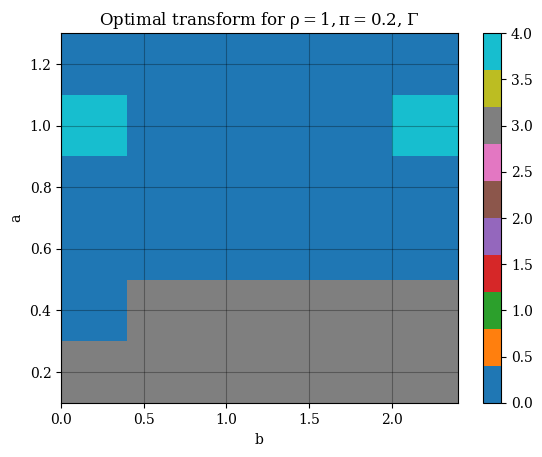

(array([[0.2, 0.6, 1. , 1.4, 1.8, 2.2],
        [0.2, 0.6, 1. , 1.4, 1.8, 2.2],
        [0.2, 0.6, 1. , 1.4, 1.8, 2.2],
        [0.2, 0.6, 1. , 1.4, 1.8, 2.2],
        [0.2, 0.6, 1. , 1.4, 1.8, 2.2],
        [0.2, 0.6, 1. , 1.4, 1.8, 2.2]]),
 array([[0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
        [0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
        [0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
        [1. , 1. , 1. , 1. , 1. , 1. ],
        [1.2, 1.2, 1.2, 1.2, 1.2, 1.2]]),
 array([[3., 3., 3., 3., 3., 3.],
        [0., 3., 3., 3., 3., 3.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [4., 0., 0., 0., 0., 4.],
        [0., 0., 0., 0., 0., 0.]]))

In [410]:
gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
model = sampling.WSBM(f"$\\Gamma$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
def log_likelihood_inner(X,a,b):
    trunc = scipy.stats.gamma.cdf(1, a,0,b) - scipy.stats.gamma.cdf(0, a,0,b)
    res = scipy.stats.gamma.pdf(X, a,0,b)/trunc
    res[res == scipy.stats.gamma.pdf(0.999, a,0,b)] = 1
    return np.log(res)
TRANSFORMS[0][0] = log_likelihood_inner
chernoff.plot_contour_gamma(model, TRANSFORMS, 1, 5)

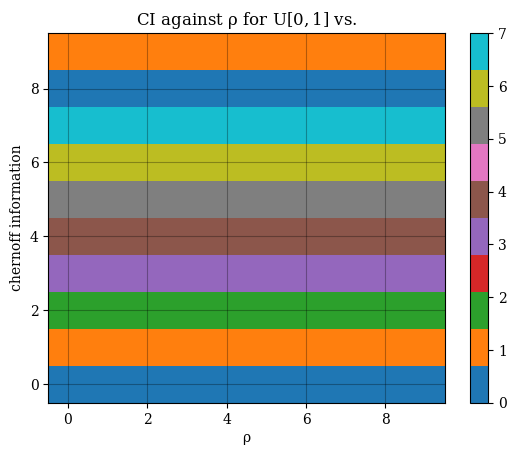

In [160]:
x, y = np.meshgrid(range(10),range(10))
z = np.ones((10,10))
for i in range(10):
    z[i] *= (i % 8)
#z = np.sin(0.5 * x) * np.cos(0.52 * y)

# Mask various z values.
#z = np.ma.array(z)

fig, ax= plt.subplots(ncols=1)
#for ax in axs:
cs = ax.pcolormesh(x, y, z, cmap='tab10')
#ax.contour(cs, c='k')
ax.set_title(f"CI against $\\rho$ for $U[0,1]$ vs.")

# Plot grid.
ax.grid(c='k', alpha=0.3)

plt.xlabel("$\\rho$")
plt.ylabel("chernoff information")
fig.colorbar(cs)
plt.show()

In [161]:
import pickle
with open("wah.pkl", "wb") as f:
    pickle.dump("wah",f)

100%|██████████| 31/31 [04:48<00:00,  9.30s/it]


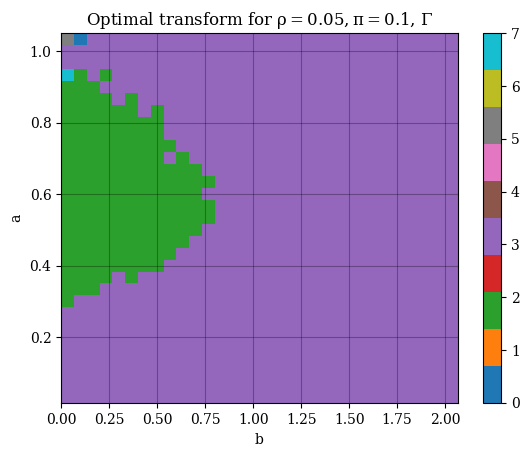

100%|██████████| 31/31 [04:41<00:00,  9.08s/it]


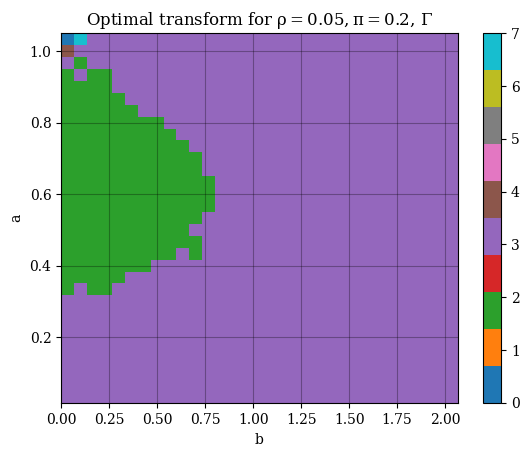

100%|██████████| 31/31 [04:34<00:00,  8.86s/it]


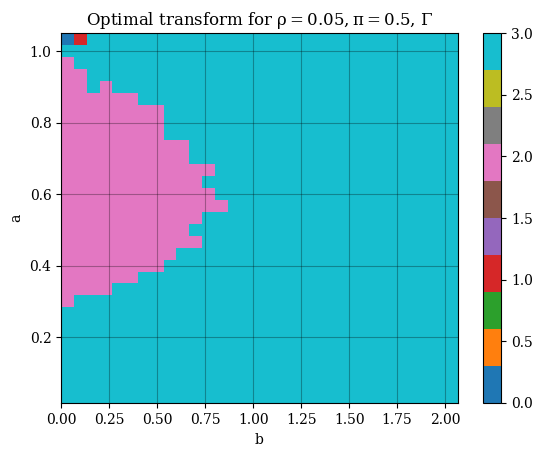

100%|██████████| 31/31 [04:54<00:00,  9.51s/it]


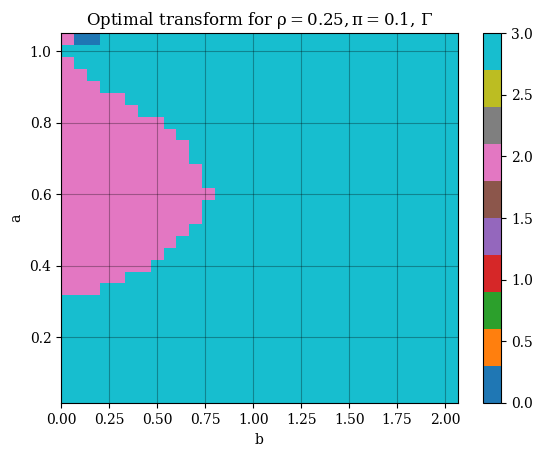

100%|██████████| 31/31 [04:55<00:00,  9.53s/it]


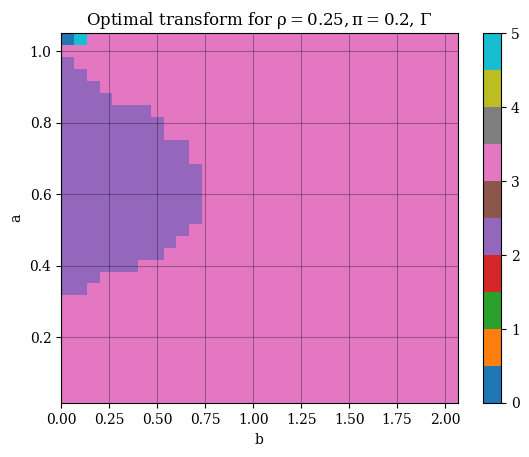

100%|██████████| 31/31 [04:54<00:00,  9.50s/it]


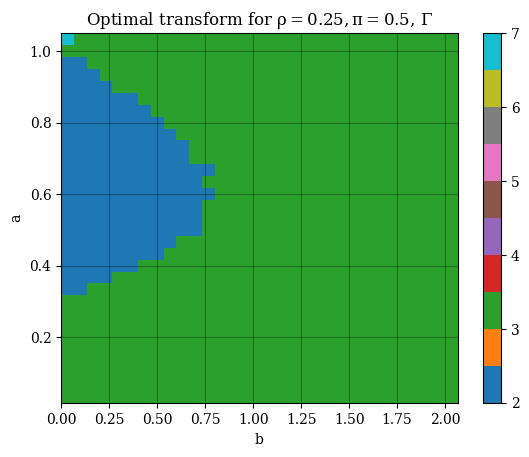

100%|██████████| 31/31 [05:08<00:00,  9.95s/it]


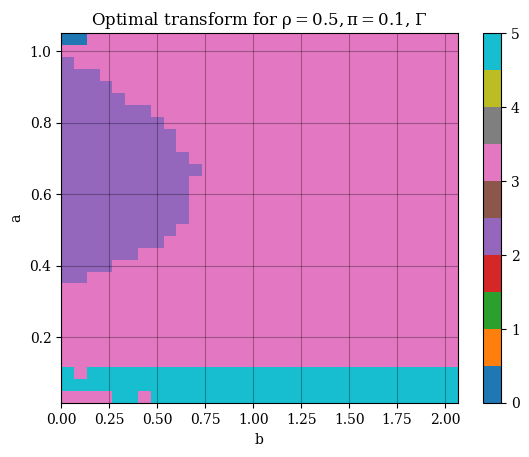

100%|██████████| 31/31 [05:09<00:00,  9.98s/it]


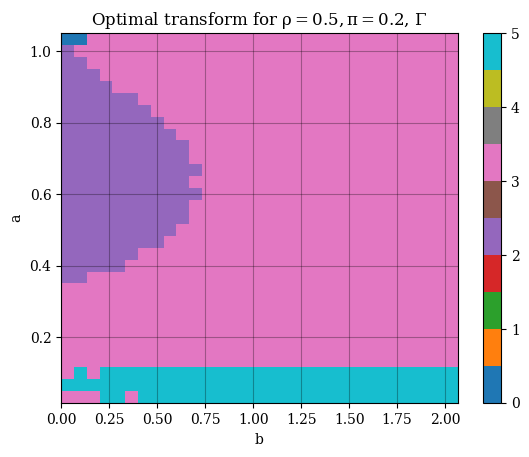

100%|██████████| 31/31 [05:09<00:00,  9.99s/it]


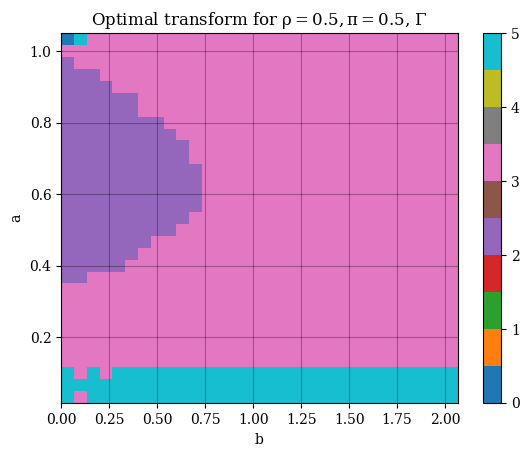

100%|██████████| 31/31 [04:14<00:00,  8.22s/it]


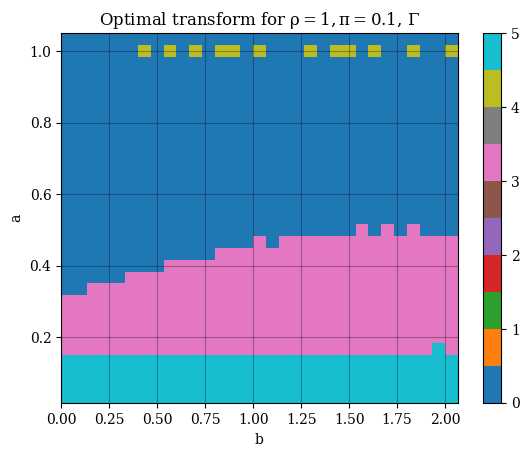

100%|██████████| 31/31 [04:15<00:00,  8.26s/it]


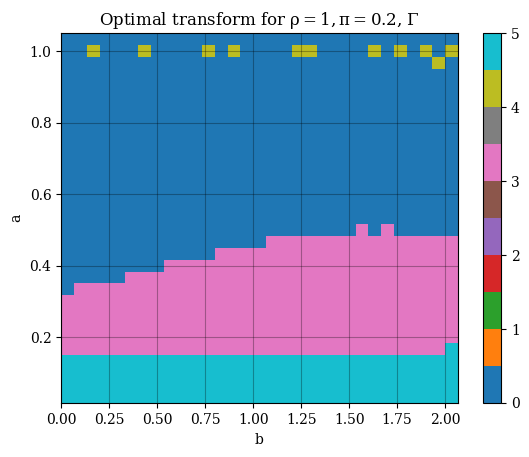

100%|██████████| 31/31 [04:17<00:00,  8.29s/it]


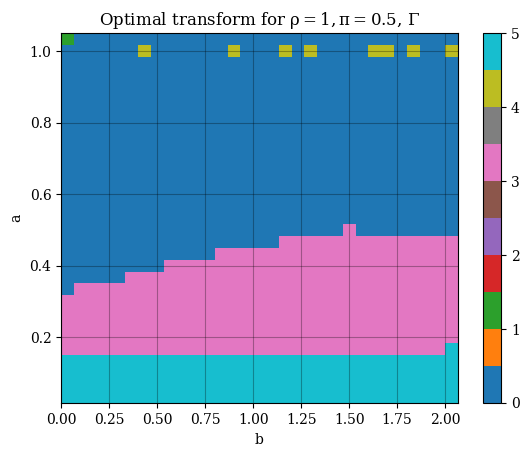

In [163]:
results = [[0 for _ in range(3)] for _ in range(4)]

for i,rho in enumerate([0.05, 0.25, 0.5, 1]):
    for j,pi in enumerate([0.1, 0.2, 0.5]):
        gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
        model = sampling.WSBM(f"$\\Gamma$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
        def log_likelihood_inner(X,a,b):
            trunc = scipy.stats.gamma.cdf(1, a,0,b) - scipy.stats.gamma.cdf(0, a,0,b)
            res = scipy.stats.gamma.pdf(X, a,0,b)/trunc
            res[res == scipy.stats.gamma.pdf(0.999, a,0,b)] = 1
            return np.log(res)
        TRANSFORMS[0][0] = log_likelihood_inner
        results[i][j] = chernoff.plot_contour_gamma(model, TRANSFORMS, rho, 30)
with open("gamma_asymm.pkl", "wb") as f:
    pickle.dump(results,f)

In [164]:
results = [[0 for _ in range(3)] for _ in range(4)]


for i,rho in enumerate([0.05, 0.25, 0.5, 1]):
    for j,pi in enumerate([0.1, 0.2, 0.5]):
        beta_dists, beta_params = sampling.standard_dist_matrix(scipy.stats.beta, [0.5,1])
        model = sampling.WSBM(f"$\\Beta$", beta_dists, beta_params, np.array([pi,1 - pi]))
        def log_likelihood_inner(X,a,b):
            trunc = scipy.stats.beta.cdf(1, a,b) - scipy.stats.beta.cdf(0, a,b)
            res = scipy.stats.beta.pdf(X, a,b)/trunc
            res[res == scipy.stats.beta.pdf(0.999, a,b)] = 1
            return np.log(res)
        TRANSFORMS[0][0] = log_likelihood_inner
        results[i][j] = chernoff.plot_contour_beta(model, TRANSFORMS, rho, 30)
with open("beta_asymm.pkl", "wb") as f:
    pickle.dump(results,f)

100%|██████████| 31/31 [05:55<00:00, 11.46s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [05:55<00:00, 11.47s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [05:56<00:00, 11.51s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [06:27<00:00, 12.50s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [06:28<00:00, 12.52s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [06:28<00:00, 12.55s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [06:52<00:00, 13.29s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [06:51<00:00, 13.28s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [06:52<00:00, 13.30s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [05:48<00:00, 11.24s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [05:48<00:00, 11.23s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [05:49<00:00, 11.28s/it]


ValueError: 
\Beta
^
ParseFatalException: Unknown symbol: \Beta, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 2 Axes>

100%|██████████| 31/31 [06:08<00:00, 11.89s/it]


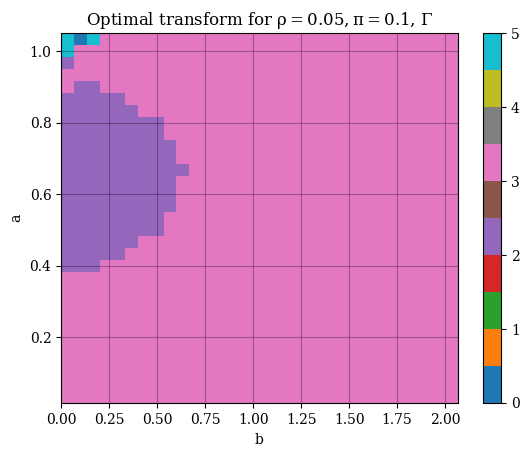

100%|██████████| 31/31 [05:55<00:00, 11.48s/it]


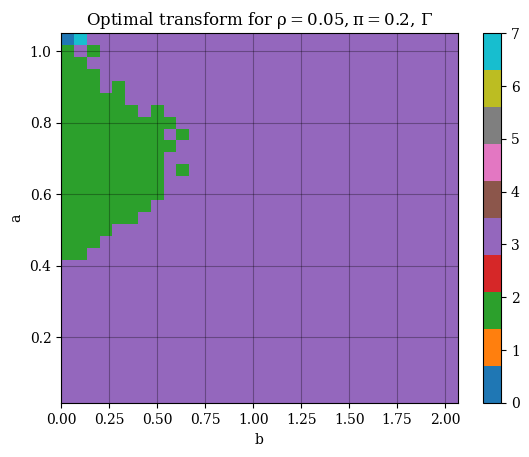

100%|██████████| 31/31 [06:02<00:00, 11.68s/it]


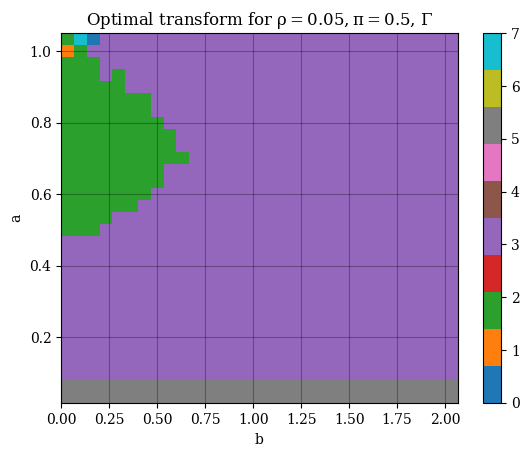

100%|██████████| 31/31 [06:28<00:00, 12.53s/it]


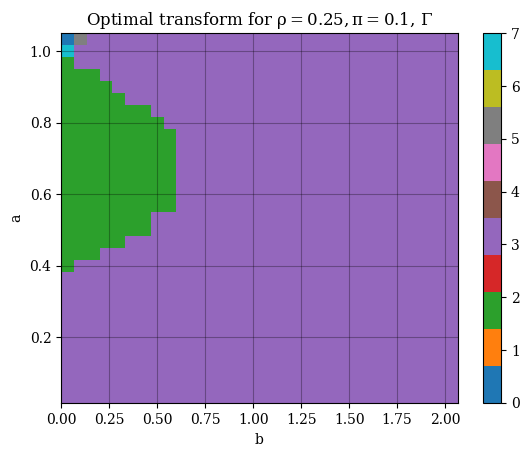

100%|██████████| 31/31 [06:17<00:00, 12.18s/it]


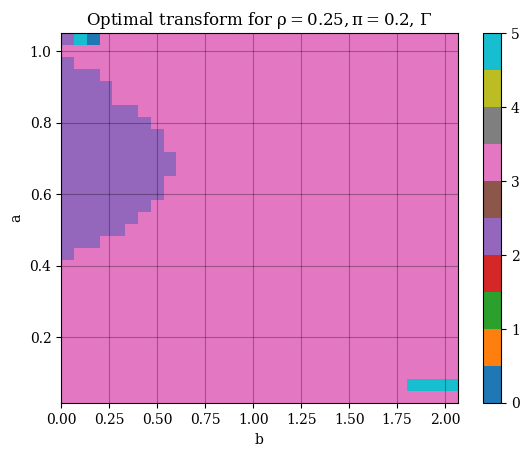

100%|██████████| 31/31 [06:15<00:00, 12.12s/it]


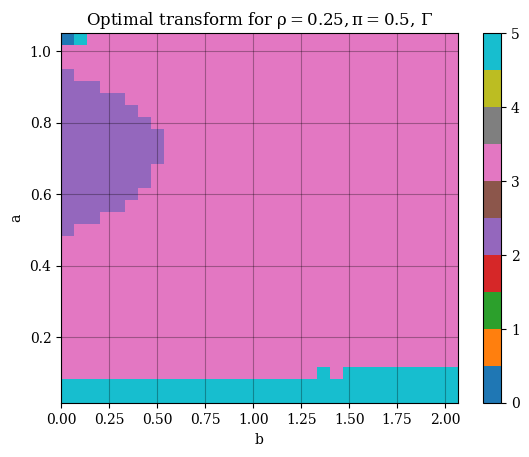

100%|██████████| 31/31 [06:45<00:00, 13.06s/it]


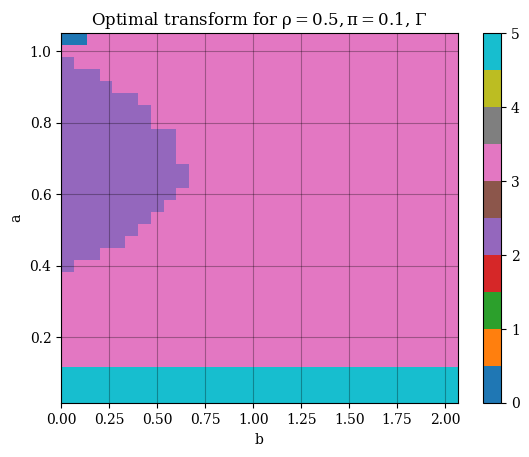

100%|██████████| 31/31 [06:47<00:00, 13.14s/it]


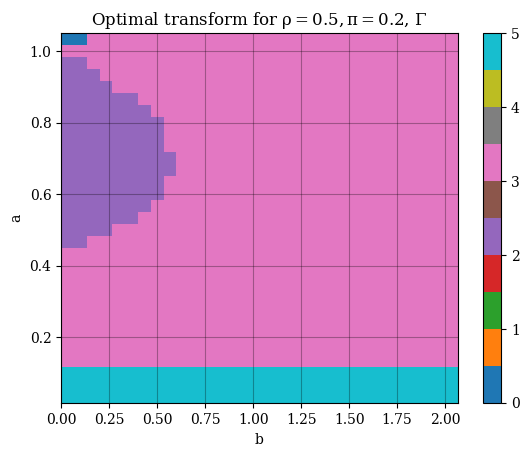

100%|██████████| 31/31 [06:42<00:00, 12.99s/it]


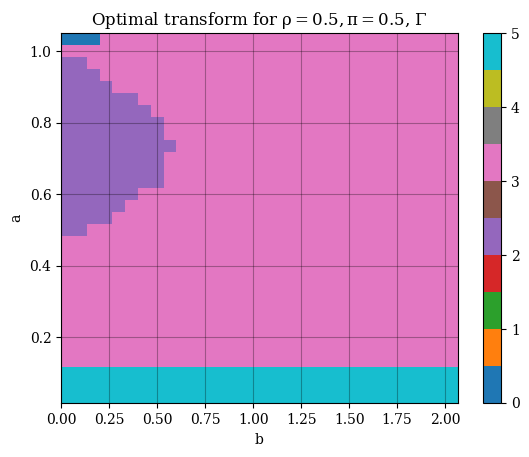

100%|██████████| 31/31 [05:43<00:00, 11.10s/it]


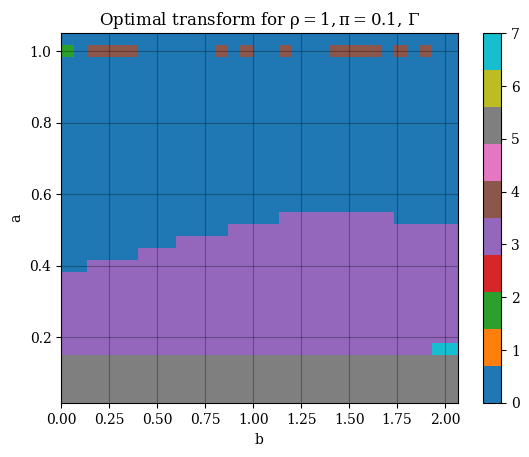

100%|██████████| 31/31 [05:46<00:00, 11.18s/it]


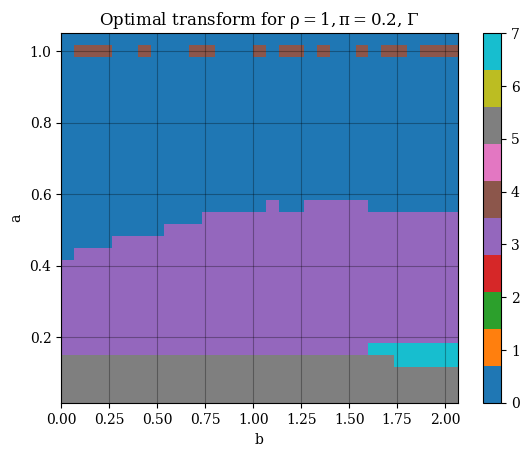

100%|██████████| 31/31 [05:36<00:00, 10.85s/it]


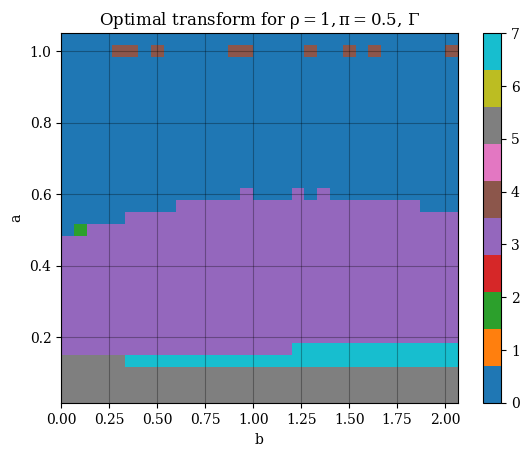

In [165]:
results = [[0 for _ in range(3)] for _ in range(4)]


for i,rho in enumerate([0.05, 0.25, 0.5, 1]):
    for j,pi in enumerate([0.1, 0.2, 0.5]):
        gamma_dists, gamma_params = sampling.symmetric_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
        model = sampling.WSBM(f"$\\Gamma$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
        def log_likelihood_inner(X,a,b):
            trunc = scipy.stats.gamma.cdf(1, a,0,b) - scipy.stats.gamma.cdf(0, a,0,b)
            res = scipy.stats.gamma.pdf(X, a,0,b)/trunc
            res[res == scipy.stats.gamma.pdf(0.999, a,0,b)] = 1
            return np.log(res)
        TRANSFORMS[0][0] = log_likelihood_inner
        results[i][j] = chernoff.plot_contour_gamma(model, TRANSFORMS, rho, 30, symm = True)
with open("gamma_symm.pkl", "wb") as f:
    pickle.dump(results,f)

100%|██████████| 31/31 [07:43<00:00, 14.95s/it]


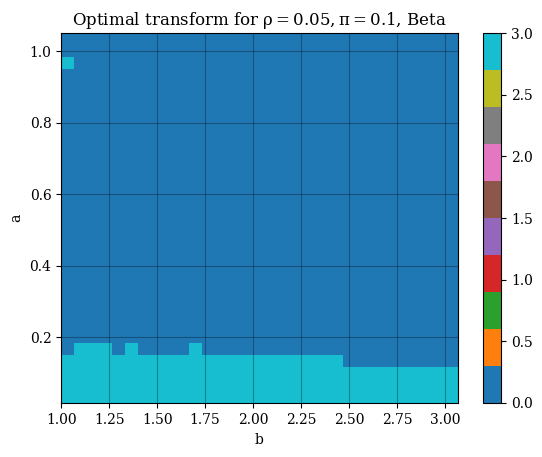

100%|██████████| 31/31 [07:46<00:00, 15.05s/it]


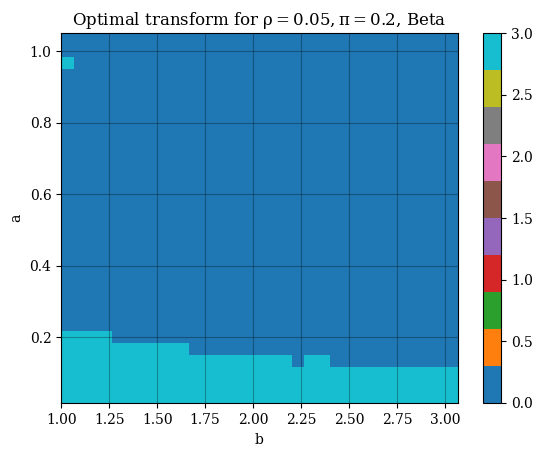

100%|██████████| 31/31 [07:41<00:00, 14.90s/it]


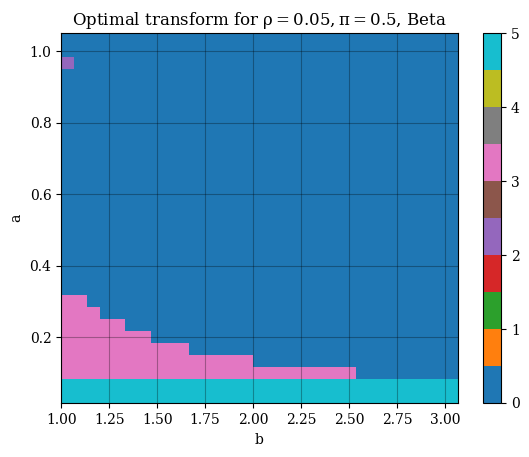

100%|██████████| 31/31 [08:15<00:00, 15.98s/it]


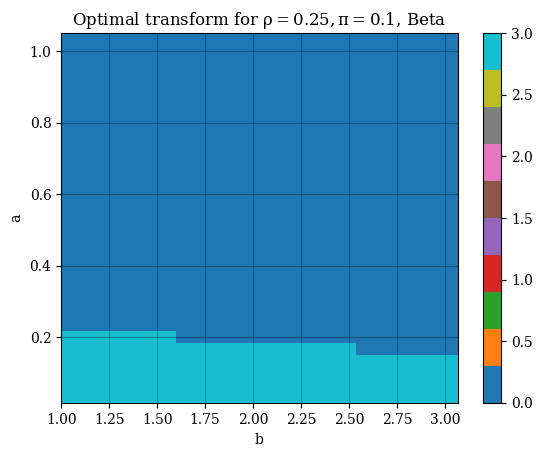

100%|██████████| 31/31 [08:21<00:00, 16.19s/it]


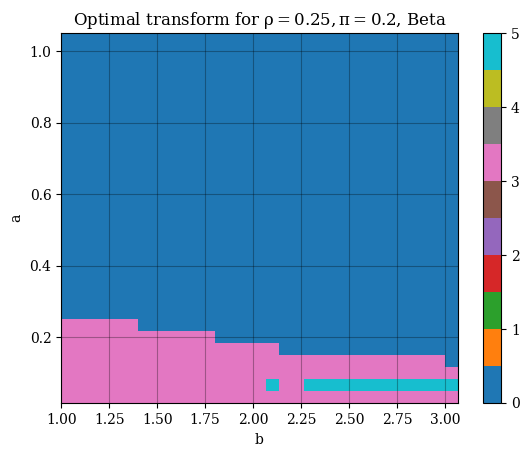

100%|██████████| 31/31 [08:16<00:00, 16.02s/it]


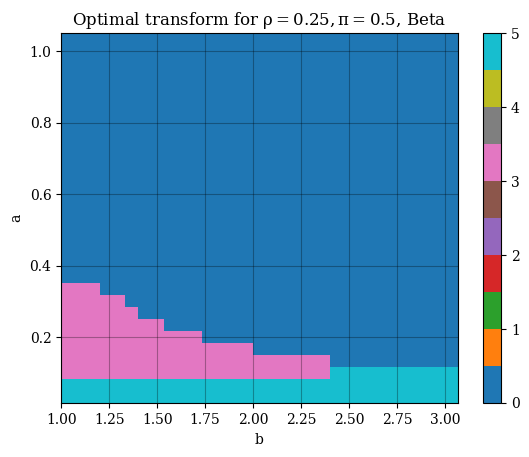

100%|██████████| 31/31 [09:17<00:00, 17.97s/it]


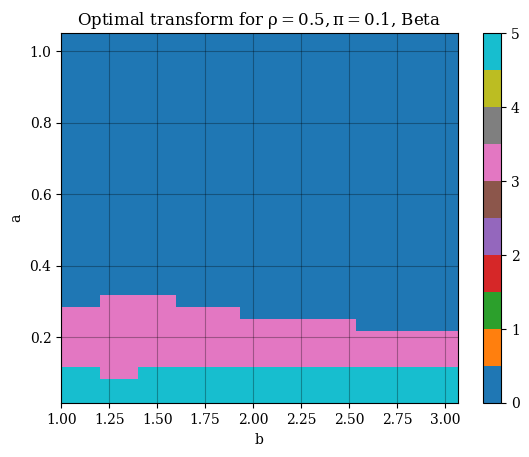

100%|██████████| 31/31 [11:05<00:00, 21.48s/it]


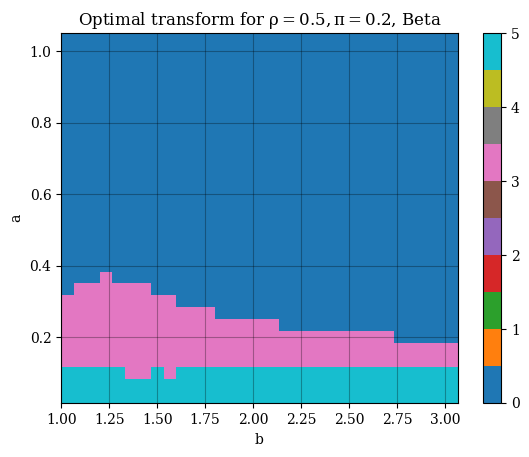

100%|██████████| 31/31 [12:28<00:00, 24.15s/it]


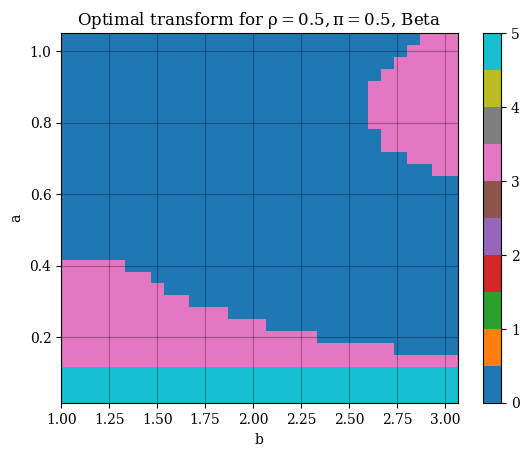

100%|██████████| 31/31 [08:20<00:00, 16.15s/it]


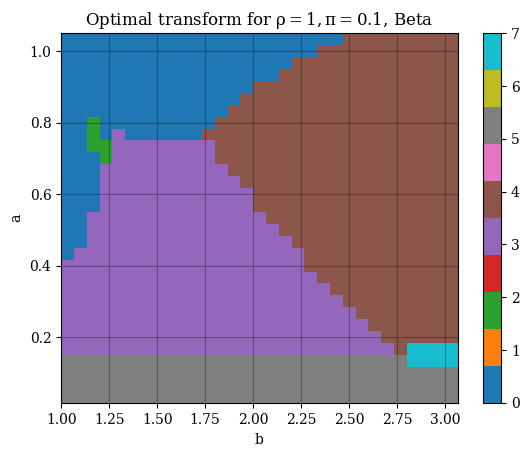

100%|██████████| 31/31 [07:31<00:00, 14.56s/it]


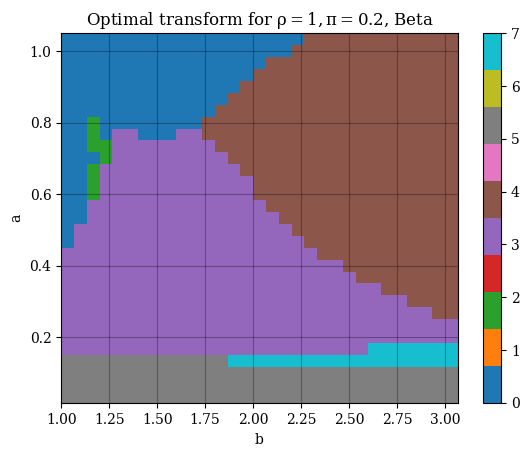

100%|██████████| 31/31 [07:50<00:00, 15.18s/it]


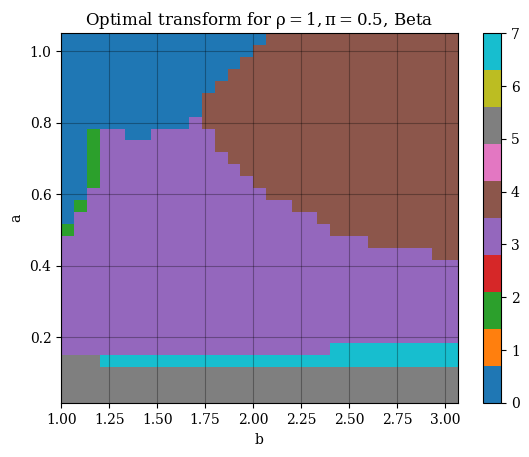

In [166]:
results = [[0 for _ in range(3)] for _ in range(4)]


for i,rho in enumerate([0.05, 0.25, 0.5, 1]):
    for j,pi in enumerate([0.1, 0.2, 0.5]):
        beta_dists, beta_params = sampling.symmetric_dist_matrix(scipy.stats.beta, [0.5,1])
        model = sampling.WSBM(f"$Beta$", beta_dists, beta_params, np.array([pi,1 - pi]))
        def log_likelihood_inner(X,a,b):
            trunc = scipy.stats.beta.cdf(1, a,b) - scipy.stats.beta.cdf(0, a,b)
            res = scipy.stats.beta.pdf(X, a,b)/trunc
            res[res == scipy.stats.beta.pdf(0.999, a,b)] = 1
            return np.log(res)
        TRANSFORMS[0][0] = log_likelihood_inner
        results[i][j] = chernoff.plot_contour_beta(model, TRANSFORMS, rho, 30, symm = True)
with open("beta_symm.pkl", "wb") as f:
    pickle.dump(results,f)

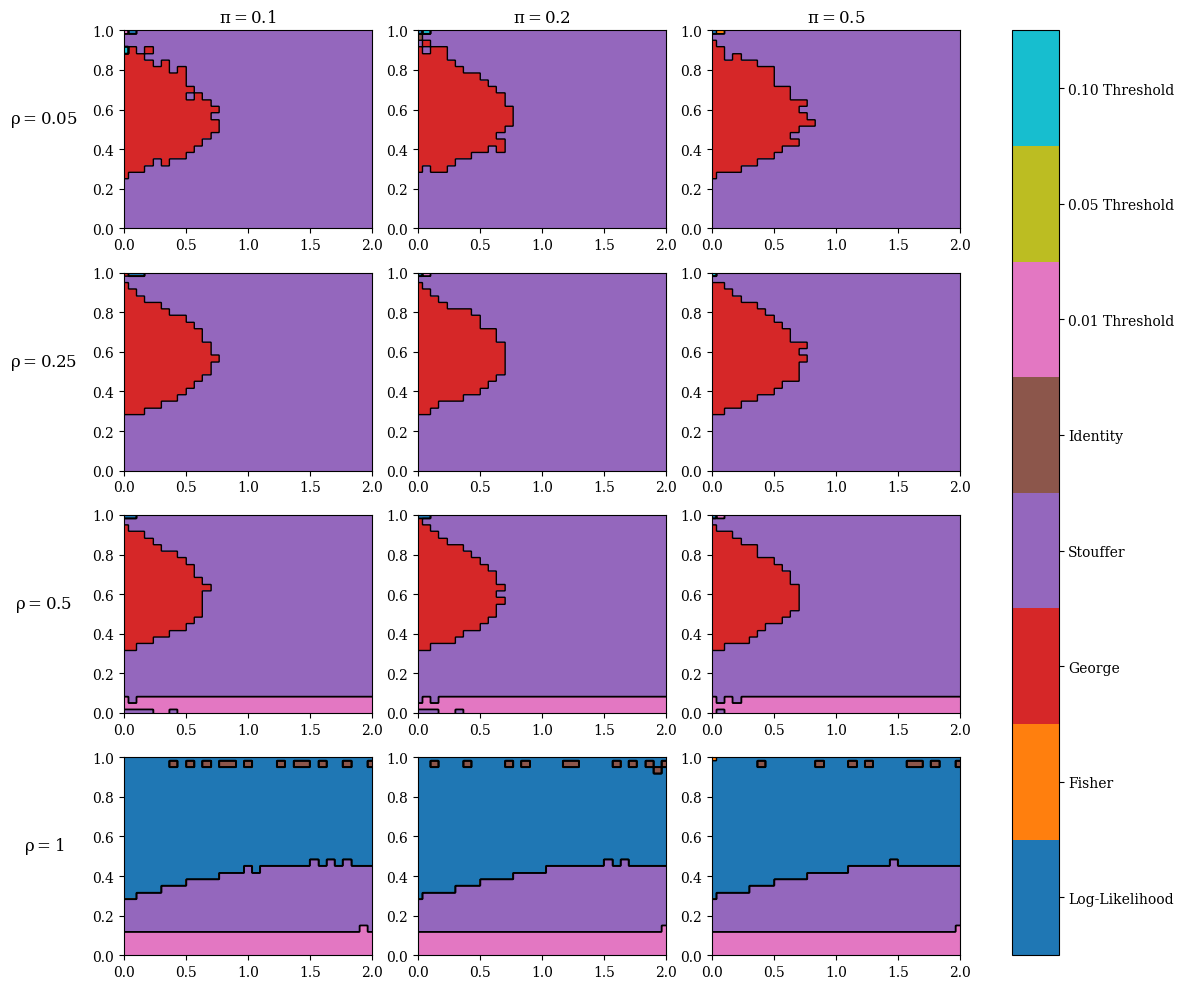

In [331]:
with open("gamma_asymm.pkl", "rb") as f:
    results = pickle.load(f)
import itertools
rhos = [0.05, 0.25, 0.5, 1]
pis = [0.1, 0.2, 0.5]
fig, ax= plt.subplots(ncols=3,nrows=4,figsize=(12,10))
cols = ["$\\pi = 0.1$", "$\\pi = 0.2$", "$\\pi = 0.5$"]
rows = ["$\\rho = 0.05$", "$\\rho = 0.25$", "$\\rho = 0.5$","$\\rho = 1$"]

for axx, col in zip(ax[0], cols):
    axx.set_title(col)

for axx, row in zip(ax[:,0], rows):
    axx.set_ylabel(row, rotation=0, size='large', labelpad=35)


fig.tight_layout()
for i in range(4):
    for j in range(3):
        x,y,res = results[i][j]
        res += 0.5
        res = scipy.ndimage.zoom(res, 10, order=0)
        #bounds = scipy.ndimage.zoom(bounds, 10, order=2)
        #bounds[bounds < 0.95] = 0
        #for ax in axs:
        cs = ax[i][j].contourf(np.linspace(np.round(np.min(x), 0),np.round(np.max(x), 0),len(res)), np.linspace(np.round(np.min(y), 0),np.round(np.max(y), 0),len(res)), res, levels=[0,1,2,3,4,5,6,7,8],cmap='tab10')
        ax[i][j].contour(cs, colors='black',linewidths=1)
        
        #plt.ylabel("a")
        #plt.xlabel("b")
cbar = plt.colorbar(cs, ax=ax, ticks=np.arange(0.5, 8.5, 1))
cbar.ax.set_yticklabels([algorithm[1] for algorithm in TRANSFORMS])
#plt.show()
plt.savefig("gamma_asymm.svg")


In [360]:

xs = np.linspace(0.01, 1, 50)
ys = np.linspace(0.01, 2, 50)
res = np.zeros((50,50))
for i in tqdm(range(len(xs))):
    for j in range(len(xs)):
        res[i][j] = np.mean(sampling.truncated_sample(scipy.stats.gamma, [xs[i],0,1/ys[j]], 1, 100_000))
res = scipy.ndimage.zoom(res, 3, order=1)

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


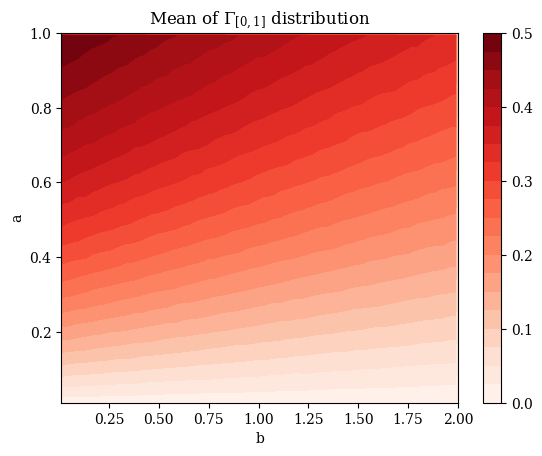

In [361]:

fig, ax= plt.subplots()
cs = ax.contourf(np.linspace(0.01, 2, 150),np.linspace(0.01, 1, 150),res,levels=20,cmap="Reds",vmin=0,vmax=0.5)
#ax[i][j].contour(cs, colors='black',linewidths=1)
cbar = plt.colorbar(cs)
cbar.set_ticks(np.arange(0, 0.51, 0.1)) 
plt.ylabel("a")
plt.xlabel("b")
plt.title("Mean of $\\Gamma_{[0,1]}$ distribution")
#cbar = plt.colorbar(cs, ax=ax, ticks=np.arange(0.5, 8.5, 1))
#cbar.ax.set_yticklabels([algorithm[1] for algorithm in TRANSFORMS])
#plt.show()
plt.savefig("gamma_mean.svg")

In [ ]:

bounds = np.zeros(res.shape)
for k in range(len(bounds)):
    for l in range(len(bounds)):
        for dx in [0,1]:
            if k + dx < 0 or k + dx >= len(bounds): continue
            for dy in [0,1]:
                if l + dy < 0 or l + dy >= len(bounds): continue
                if res[k + dx, l + dy] != res[k,l]: bounds[k][l] = 1
vertices = []
for k in range(1,len(bounds)-1):
    for l in range(1,len(bounds)-1):
        if bounds[k][l] == 0: continue

        if (bounds[k+1][l] > 0 or bounds[k-1][l] > 0) and (bounds[k][l+1] > 0 or bounds[k][l-1] > 0):
            bounds[k][l] = 1
            order = np.array([bounds[k+1][l] > 0,bounds[k-1][l] > 0,bounds[k][l+1] > 0,bounds[k][l-1] > 0]).sum()
            vertices.append((k,l, order))
a = vertices[1]


        fig, ax= plt.subplots(ncols=1)
        #for ax in axs:
        cmap = plt.get_cmap('tab10', 6) 
        cs = ax.pcolormesh(x, y, res + 0.5, cmap=cmap)
        #ax.contour(cs, c='k')
        ax.set_title(f"Optimal transform for $\\rho ={rho}, \\pi = {pi}$, Beta")

        # Plot grid.
        ax.grid(c='k', alpha=0.3)

        plt.xlabel("$b$")
        plt.ylabel("$a$")
        print(res)
        plt.colorbar(cs)
        #cbar = plt.colorbar(cs, ax=ax, ticks=np.arange(0.25, 5.25, 1))
        #cbar.ax.set_yticklabels(['Alg0', 'Alg1', 'Alg2', 'Alg3', 'Alg4'])
        plt.show()

                # Interpolate the grid to a higher resolution
        high_res_factor = 30 # Increase this for smoother plots
        interpolated_grid = np.round(scipy.ndimage.zoom(res, high_res_factor, order=1, prefilter=False),0)
        points = 10 * np.array(list(itertools.product(range(len(res)), repeat = 2)))
        values = np.array([res[k,l] for k,l in itertools.product(range(len(res)), repeat = 2)])
        print (values.shape, points.shape)
        grid_x, grid_y = np.mgrid[0:len(res)*10:1000j, 0:len(res)*10:1000j]
        interpolated_grid = scipy.interpolate.griddata(points, values, (grid_x,grid_y), method='cubic')
        print("IG",interpolated_grid.shape)
        # Create the plot
        fig, ax = plt.subplots(figsize=(8, 8)) # Assuming 5 distinct algorithms

        # Using pcolormesh for the higher resolution grid
        x = np.linspace(0, 1, interpolated_grid.shape[1])
        y = np.linspace(0, 1, interpolated_grid.shape[0])
        xx, yy = np.meshgrid(x, y)

        # Plotting with pcolormesh
        c = ax.pcolormesh(xx, yy, interpolated_grid, cmap=cmap)

        # Add a colorbar with algorithm labels
        cbar = plt.colorbar(c, ax=ax, ticks=np.arange(0.5, 5.5, 1))
        cbar.ax.set_yticklabels(['Alg0', 'Alg1', 'Alg2', 'Alg3', 'Alg4'])

        plt.xlabel('Parameter 1')
        plt.ylabel('Parameter 2')
        plt.title('Optimal Algorithm in 2D Parameter Space')

        plt.show()
